In [3]:
# imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.special import lambertw
import time 

# <font color=red> I.Generation of synthetic data </font>

In [4]:
#load data
url = "http://www-syscom.univ-mlv.fr/~chouzeno/ECP/Slides/x.txt"
import os
os.system(f"wget -c --user ECP --password Optim {url}")
f = open("x.txt", 'r') 
s=[]
for c in f.readlines():     
    s.append(float(c) )
xbar= np.asarray(s)

#verify the size of the signal
N = xbar.shape[0]
print("Size of the diffusion signal is N = ",N)

Size of the diffusion signal is N =  200


In [5]:
#Create T using an exponential sampling strategy 

T_min = 1
T_max = 1000
T = np.zeros(N)
for n in range(N): 
  T[n]= T_min * np.exp(-n*np.log(T_min/T_max)/(N-1))

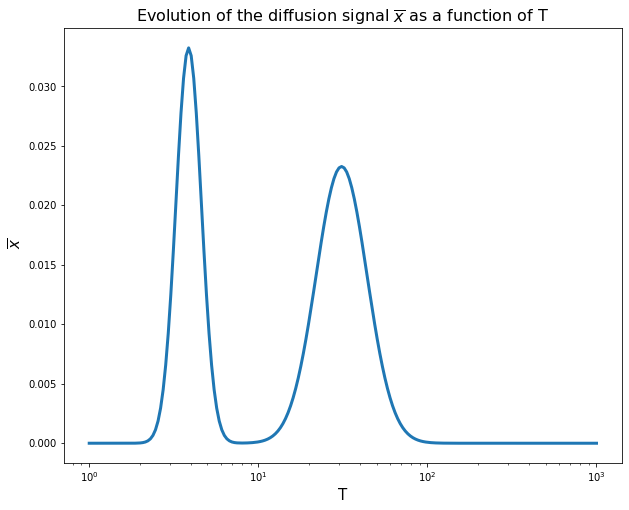

In [6]:
#Display the original signal xbar as a function of T

fig=plt.figure(figsize = (10,8))
plt.plot(T,xbar,linewidth=3)
plt.xscale("log")
plt.ylabel(" $\\overline{x}$",fontsize=15)
plt.xlabel("T",fontsize=15)
plt.title("Evolution of the diffusion signal $\\overline{x}$ as a function of T",fontsize=16)
plt.show()

In [7]:
#Create t using a regular sampling strategy

M = 50
t_min = 0
t_max = 1.5
t = np.zeros(M)
for m in range(M):
  t[m] = t_min + m*(t_max - t_min)/(M-1)

In [8]:
#Create the matrix K

K = np.zeros((M,N))
for m in range(M):
  for n in range(N):
    K[m,n] = np.exp(-t[m]*T[n])

In [9]:
#Create the noisy signal y 

z = K@xbar
sigma = 0.01*z[0]
w = np.random.multivariate_normal(mean = np.zeros(M),cov = (sigma**2)*np.eye(M))
y = z + w

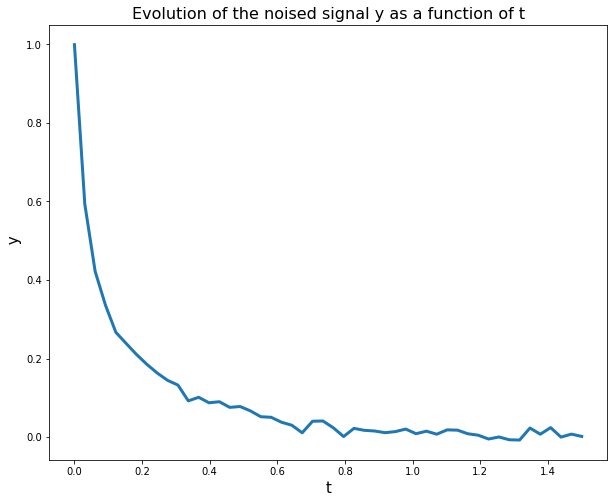

In [10]:
#Display the original signal y as a function of t

fig=plt.figure(figsize = (10,8))
plt.plot(t,y,linewidth=3)
plt.ylabel(" y",fontsize=15)
plt.xlabel("t",fontsize=15)
plt.title("Evolution of the noised signal y as a function of t",fontsize=16)
plt.show()

# <font color=red> II. Comparison of regularization strategies </font>


## <font color=blue >1. Unconstrained Smoothness prior </font>

In [11]:
#Create the difference matrix

D = np.eye(N)- np.eye(N,k=-1)
D[0,N-1]=-1
print(D)

[[ 1.  0.  0. ...  0.  0. -1.]
 [-1.  1.  0. ...  0.  0.  0.]
 [ 0. -1.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ... -1.  1.  0.]
 [ 0.  0.  0. ...  0. -1.  1.]]


In [12]:
def unconstrained_smooth_prior(beta,y = y ,K = K ,D = D):
  x = np.linalg.solve(K.T@K + beta * D.T @ D,K.T@y)
  return x, np.linalg.norm(x - xbar,ord=2)/ np.linalg.norm(xbar,ord=2)

In [13]:
#searching the optimal beta that yields the minimum error with the unconstrained smoothness prior

list_beta = [2**i for i in range(-20,5)]
beta_Opt = min (list_beta , key = lambda beta : unconstrained_smooth_prior(beta)[1])
print("The optimal beta in terms of reconstruction error between the estimated object and the ground truth = ", beta_Opt)
t = time.time()
x1,err1 = unconstrained_smooth_prior(beta_Opt)
print("The error corresponding to the optimal beta is = ",err1)
print("Required time for computing the solution = ", round(time.time()-t,3)," s")

The optimal beta in terms of reconstruction error between the estimated object and the ground truth =  0.5
The error corresponding to the optimal beta is =  0.3714135596151351
Required time for computing the solution =  0.003  s


## <font color=blue >2. Constrained Smoothness prior </font>

In [14]:
def proj(x,x_min,x_max): #projection onto C=[x_min, x_max]^N
  N = len(x)
  res = np.zeros(N)
  for i in range(N):
    if x[i] < x_min :
      res[i] = x_min
    else:
      if x[i] > x_max:
        res[i] = x_max
      else:
        res[i] = x[i]
  return res

def constrained_smooth_prior(beta, y = y,K = K, max_iter = 100, eps = 1e-10):
  _,N = K.shape
  nu = max(np.linalg.eigvals(K.T@K+ beta * D.T@D ))
  gamma = 1/nu 
  delta = 2 - gamma*nu/2
  lamda = 0.99*delta 
  x_old = 0.5*(max(xbar) + min(xbar))*np.ones(N)
  test = True
  iteration = 0
  x_seq=[x_old] #sequence of x along iterations
  while test and (iteration < max_iter):
    y_new = x_old - gamma *(K.T @ (K @ x_old -y) + beta * D.T @ (D @ x_old))
    x_new = x_old + lamda *(proj(y_new,min(xbar),max(xbar)) - x_old)
    x_seq.append(x_new)
    iteration +=1
    err =  np.linalg.norm(x_old - x_new,ord=2)/ np.linalg.norm(x_old,ord=2)
    test = err > eps
    x_old = x_new 
  return x_seq , np.linalg.norm(x_new - xbar,ord=2)/ np.linalg.norm(xbar,ord=2)
  

In [15]:
#searching the optimal beta that yields the minimum error with the constrained smoothness prior

list_beta = [2**i for i in range(-20,5)]
beta_Opt = min (list_beta , key = lambda beta : constrained_smooth_prior(beta)[1])
print("The optimal beta in terms of reconstruction error between the estimated object and the ground truth = ", beta_Opt)
t = time.time()
x2_seq,err2 = constrained_smooth_prior(beta_Opt)
print("The error corresponding to the optimal beta is = ",err2)
print("Required time for computing the solution = ", round(time.time()-t,3)," s")

The optimal beta in terms of reconstruction error between the estimated object and the ground truth =  8
The error corresponding to the optimal beta is =  0.7581068048614822
Required time for computing the solution =  0.098  s


## <font color=blue >3. Sparsity prior </font>

In [16]:
def prox_norm_1(y,gamma): #proximal of L1-norm
  n=len(y)
  res = np.zeros(n)
  for i in range(n):
    if y[i] <0:
      sign = -1
    else:
      sign = 1
    res[i] = sign * max(0,abs(y[i])-gamma)
  return res

def sparsity_prior(beta, y = y,K = K, max_iter = 100, eps = 1e-10):
  _,N = K.shape
  nu = max(abs(np.linalg.eigvals(K.T@K)))
  gamma = 1.999/nu 
  delta = 2 - gamma*nu/2
  lamda = 0.999*delta 
  x_old = 0.5*(max(xbar) + min(xbar))*np.ones(N)
  test = True
  iteration = 0
  x_seq=[x_old] #sequence of x along iterations
  while test and (iteration < max_iter):
    y_new = x_old - gamma * K.T @ (K @ x_old - y)
    x_new = x_old + lamda *(prox_norm_1(y_new,gamma*beta) - x_old)
    x_seq.append(x_new)
    iteration +=1
    err = np.linalg.norm(x_new - x_old,ord=2)/ np.linalg.norm(x_old,ord=2)
    test = err > eps
    x_old = x_new 
  return x_seq, np.linalg.norm(x_new - xbar,ord = 2)/np.linalg.norm(xbar,ord = 2)
  

In [17]:
#searching the optimal beta that yields the minimum error with the sparsity prior

list_beta = [2**i for i in range(-20,5)]
beta_Opt = min (list_beta , key = lambda beta : sparsity_prior(beta)[1])
print("The optimal beta in terms of reconstruction error between the estimated object and the ground truth = ", beta_Opt)
t = time.time()
x3_seq,err3 = sparsity_prior(beta_Opt)
print("The error corresponding to the optimal beta is = ",err3)
print("Required time for computing the solution = ", round(time.time()-t,3)," s")

The optimal beta in terms of reconstruction error between the estimated object and the ground truth =  0.125
The error corresponding to the optimal beta is =  0.7829435539560734
Required time for computing the solution =  0.11  s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


## <font color=blue> 4.Comparing the three strategies </font>

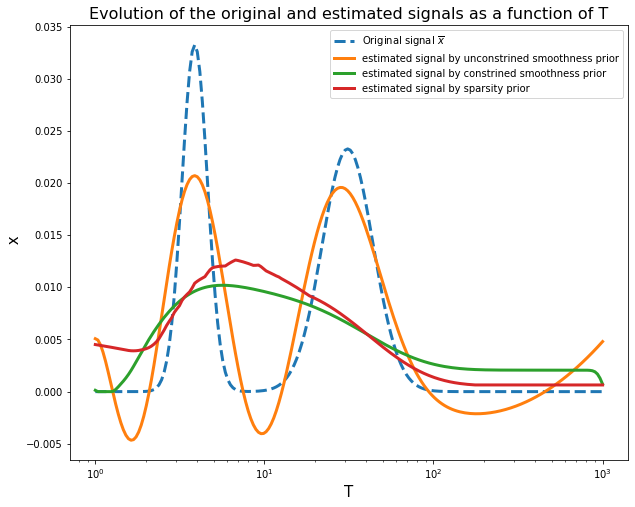

In [18]:
#Display the estimated signals as a function of T

fig=plt.figure(figsize = (10,8))
plt.plot(T,xbar,linewidth=3,linestyle='dashed',label="Original signal $\\overline{x}$")
plt.plot(T,x1,linewidth=3,label="estimated signal by unconstrined smoothness prior")
plt.plot(T,x2_seq[-1],linewidth=3,label="estimated signal by constrined smoothness prior")
plt.plot(T,x3_seq[-1],linewidth=3,label="estimated signal by sparsity prior")
plt.xscale("log")
plt.ylabel(" x",fontsize=15)
plt.xlabel("T",fontsize=15)
plt.title("Evolution of the original and estimated signals as a function of T",fontsize=16)
plt.legend()
plt.show()

# <font color  = red> III. Maximum entropy regularization </font>

In [19]:
#Entropy function

def entropy(x):
  s=0
  for i in range(len(x)):
    if x[i]<0:
      return np.inf
    else:
      if x[i]>0:
        s += x[i]*np.log(x[i])
  return s

## <font color=blue> 1. Backward Forward Algorithm

In [54]:
def prox_entropy(x,gamma): #proximal of entropy
  N = len(x)
  y = np.zeros(N)
  for i in range(N):
    z = gamma* lambertw(np.exp(x[i]/gamma-1)/gamma).real
    if 0.5*(z-x[i])**2-gamma*z*np.log(z) < 0.5*x[i]**2:
      y[i] = z
  return y 


def forward_backward_entropy_prior(beta, y = y,K = K, max_iter = 200, eps = 1e-10):
  _,N = K.shape
  nu = max(abs(np.linalg.eigvals(K.T@K)))
  gamma = 1.5/nu 
  delta = 2 - gamma*nu/2
  lamda = 0.999*delta 
  x_old = 0.5*(max(xbar)+min(xbar))*np.ones(N)
  test = True
  iteration = 0
  x_seq=[x_old] #sequence of x along iterations
  while test and (iteration < max_iter):
    y_new = x_old - gamma * K.T @ (K @ x_old - y)
    x_new = x_old + lamda *(prox_entropy(y_new,gamma*beta) - x_old)
    #print(prox_entropy(y_new,gamma*beta))
    x_seq.append(x_new)
    iteration +=1
    err = np.linalg.norm(x_new - x_old,ord=2)/ np.linalg.norm(x_old,ord=2)
    test = err > eps
    x_old = x_new 
  return x_seq, np.linalg.norm(x_new - xbar,ord = 2)/np.linalg.norm(xbar,ord = 2)
  

## <font color=blue> 2. Douglas-Rachford Algorithm


In [21]:
def prox_quadratic(x,gamma,K, y): #proximal of L2-norm
  _,N = K.shape
  return  np.linalg.solve(np.eye(N)+gamma*K.T@K, x+gamma*K.T@y)

def Douglas_Rachford_entropy_prior(beta, y = y,K = K, D = D, max_iter = 200, eps = 1e-8):
  _,N = K.shape
  gamma = 1.8
  lamda = 1
  x_old = 0.5*(max(xbar)+min(xbar))*np.ones(N)
  test = True
  iteration = 0
  z_seq=[x_old] #sequence of z along iterations
  while test and (iteration < max_iter):
    y_new = prox_quadratic(x_old,gamma,K=K,y=y)
    z_new = prox_entropy(2*y_new-x_old,beta*gamma)
    x_new = x_old + lamda*(z_new - y_new)
    iteration +=1
    test = np.linalg.norm(x_new - x_old, ord = 2) > eps
    z_seq.append(z_new)
    x_old = x_new 
  return z_seq, np.linalg.norm(z_new - xbar,ord = 2)/np.linalg.norm(xbar,ord = 2)

## <font color = blue> 3. Comparing backward Forward and Douglas-Rachford algorithms

In [22]:
# For beta = 10^{-2}
t = time.time()
x4_seq,err4 = forward_backward_entropy_prior(1e-2)
t1 = time.time() -t

t = time.time()
x5_seq,err5 = Douglas_Rachford_entropy_prior(1e-2)
t2 = time.time() -t

print("For beta = 1e-2:")
print("+========================================================+ ")
print("|Algorithm         |  Error  |  Entropy  |  Running time |")
print("|================= + ======= + ========= + ==============| ")
print("|Forward Backward  |","{0:7}".format("%.3f" %  err4),"|","{0:9}".format("%.3f" %  entropy(x4_seq[-1])),"|","{0:14}".format("%.3f" %  t1+" s")+"|")
print("|----------------- + ------- + --------- + --------------|")
print("|Douglas-Rachford  |","{0:7}".format("%.3f" %  err5),"|","{0:9}".format("%.3f" %  entropy(x5_seq[-1])),"|","{0:14}".format("%.3f" %  t2+" s")+"|")
print("+========================================================+ ")


For beta = 1e-2:
+========================================================+ 
|Algorithm         |  Error  |  Entropy  |  Running time |
|================= + ======= + ========= + ==============| 
|Forward Backward  | 0.765   | inf       | 0.814 s       |
|----------------- + ------- + --------- + --------------|
|Douglas-Rachford  | 3.851   | -1.042    | 1.128 s       |
+========================================================+ 


In [56]:
#Search the optimal beta that ields the minimal error with forward backward algorithm

np.seterr(divide = 'ignore',over='ignore',invalid='ignore') 
list_beta = [2**i for i in range(-20,5)]
beta_Opt1 = min (list_beta , key = lambda beta : forward_backward_entropy_prior(beta)[1])

t = time.time()
x6_seq,err6 = forward_backward_entropy_prior(beta_Opt1)
t1 = time.time() - t

In [24]:
#Search the optimal beta that ields the minimal error with Douglas-Rachford algorithm

np.seterr(divide = 'ignore',over='ignore',invalid='ignore') 
list_beta = [2**i for i in range(-20,2)]
beta_Opt2 = min (list_beta , key = lambda beta : Douglas_Rachford_entropy_prior(beta)[1])

t = time.time()
x7_seq,err7 = Douglas_Rachford_entropy_prior(beta_Opt2)
t2 = time.time() - t

In [57]:
print("Optimal betas for minimal errors:")
print("+=============================================================================+ ")
print("|Algorithm         |  Optimal beta  |  Min error  |  Entropy  |  Running time |")
print("|================= + ============== + =========== + ========= + ==============| ")
print("|Forward Backward  |","{0:14}".format("%.10f" %  beta_Opt1),"|","{0:11}".format("%.3f" %  err6),"|","{0:9}".format("%.3f" %  entropy(x6_seq[-1])),"|","{0:14}".format("%.3f" %  t1+" s")+"|")
print("|----------------- + -------------- + ----------- + --------- + --------------|")
print("|Douglas-Rachford  |","{0:14}".format("%.10f" %  beta_Opt2),"|","{0:11}".format("%.3f" %  err7),"|","{0:9}".format("%.3f" %  entropy(x7_seq[-1])),"|","{0:14}".format("%.3f" %  t2+" s")+"|")
print("+=============================================================================+ ")


Optimal betas for minimal errors:
+=============================================================================+ 
|Algorithm         |  Optimal beta  |  Min error  |  Entropy  |  Running time |
|================= + ============== + =========== + ========= + ==============| 
|Forward Backward  | 0.0078125000   | 0.763       | inf       | 0.771 s       |
|----------------- + -------------- + ----------- + --------- + --------------|
|Douglas-Rachford  | 0.0000305176   | 0.156       | -4.086    | 1.140 s       |
+=============================================================================+ 


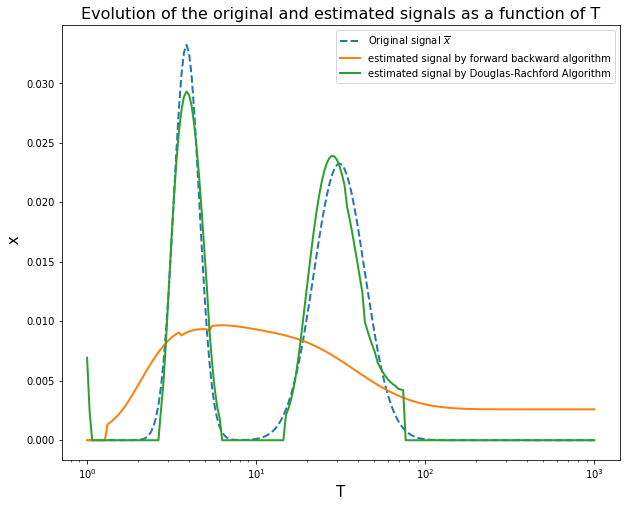

In [58]:
#Display the estimated signals as a function of T

fig=plt.figure(figsize = (10,8))
plt.plot(T,xbar,linewidth=2,linestyle='dashed',label="Original signal $\\overline{x}$")
plt.plot(T,x6_seq[-1],linewidth=2,label="estimated signal by forward backward algorithm")
plt.plot(T,x7_seq[-1],linewidth=2,label="estimated signal by Douglas-Rachford Algorithm")
plt.xscale("log")
plt.ylabel(" x",fontsize=15)
plt.xlabel("T",fontsize=15)
plt.title("Evolution of the original and estimated signals as a function of T",fontsize=16)
plt.legend(fontsize = 10)
plt.show()

## <font color=blue> 4. Optimizing Entropy with PPXA

In [47]:
def proj_ball(z,y,r): #orthogonal projection onto the closed ball of center y and radius y
  dist =  np.linalg.norm(z-y,ord=2) 
  if dist <=r: #ie z in B(y,r)
    p = z
  else:
    p = y + (r/dist)*(z-y)
  return p

def PPXA(eta, sigma = sigma, K=K, y=y, eps = 1e-7, max_iter = 200):
  M,N = K.shape
  x_old_1 = 0.5*(max(xbar)+min(xbar))*np.ones(N)
  x_old_2 = 0.5*(max(xbar)+min(xbar))*np.ones(M)
  v_old = np.linalg.solve(np.eye(N)+K.T@K, x_old_1+K.T@x_old_2 )
  test = True
  iteration = 0
  gamma = 1
  lamda = 1.5
  v_seq = [v_old]
  while test and (iteration < max_iter):
    iteration +=1
    y_new_1 = prox_entropy(x_old_1,gamma)
    y_new_2 = proj_ball(x_old_2,y,np.sqrt(eta*m)*sigma)
    c_new = np.linalg.solve(np.eye(N)+K.T@K, y_new_1+K.T@y_new_2 )
    x_new_1 = x_old_1 + lamda*(2*c_new - v_old - y_new_1)
    x_new_2 = x_old_2 + lamda*(K@(2*c_new - v_old )- y_new_2)
    v_new = v_old + lamda*(c_new - v_old)
    test = np.linalg.norm(v_new - v_old,ord=2) > eps
    v_seq.append(v_new)
    v_old = v_new
    x_old_1,x_old_2 = (x_new_1,x_new_2)
  return v_seq , np.linalg.norm(v_new - xbar,ord=2)/np.linalg.norm(xbar)


In [53]:
#tuning the optimal eta that yields the minimal entropy

list_eta = [2**i for i in range(-20,10)]
eta_Opt = min (list_eta , key = lambda eta : entropy(PPXA(eta)[0][-1]))

t = time.time()
x8_seq,err8 = PPXA(eta_Opt)
t = time.time() - t

print("+=======================================================================+ ")
print("|Algorithm |  Optimal  eta  | Min Entropy   |    Error  |  Running time |")
print("|========= + ============== + ============= + ========= + ==============| ")
print("|PPXA      |","{0:14}".format("%.10f" %  eta_Opt),"|","{0:11}".format("%.10f" %  entropy(x8_seq[-1])),"|","{0:9}".format("%.3f" %  err8),"|","{0:14}".format("%.3f" %  t+" s")+"|")
print("+=======================================================================+ ")


+=======================================================================+ 
|Algorithm |  Optimal  eta  | Min Entropy   |    Error  |  Running time |
|========= + ============== + ============= + ========= + ==============| 
|PPXA      | 0.1250000000   | -4.7314252590 | 0.584     | 1.160 s       |
+=======================================================================+ 


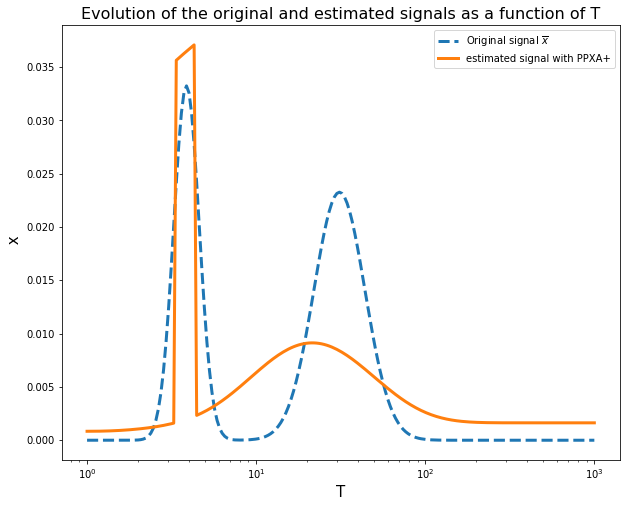

In [50]:
#Display the estimated signals as a function of T

fig=plt.figure(figsize = (10,8))
plt.plot(T,xbar,linewidth=3,linestyle='dashed',label="Original signal $\\overline{x}$")
plt.plot(T,x8_seq[-1],linewidth=3,label="estimated signal with PPXA+")
plt.xscale("log")
plt.ylabel(" x",fontsize=15)
plt.xlabel("T",fontsize=15)
plt.title("Evolution of the original and estimated signals as a function of T",fontsize=16)
plt.legend(fontsize = 10)
plt.show()